In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import pandas as pd
from pyspark.sql.types import (ArrayType, LongType, StringType, StructField, StructType, DoubleType, MapType)
import matplotlib.pyplot as plt
from plotnine import *
import plotnine as p9
import numpy as np

In [ ]:
%sql
USE DATABASE monthly_all; 

In [ ]:
df = sqlContext.sql("""
SELECT 
t.ticker, m.location_name, m.region, t.quarter_num, t.year, t.revenue, t.reported_eps, t.estimated_eps, t.eps_surprise_percentage, t.eps_beat_expectations, m.raw_visit_counts, m.raw_visitor_counts, m.visits_by_day, m.distance_from_home, m.median_dwell, m.normalized_visits_by_state_scaling, c.naics_code, m.date_range_start, m.date_range_end, m.normalized_visits_by_total_visits, m.normalized_visits_by_total_visitors 
FROM ( SELECT * , ADD_MONTHS(quarter_end, -3) AS quarter_begin FROM targets ) AS t 
LEFT JOIN sg_tickers s 
  ON s.stock_symbol = t.ticker 
LEFT JOIN core_places c 
  ON c.brand = s.safegraph_brand_id 
LEFT JOIN monthly_patterns m 
  ON m.placekey = c.placekey AND m.date_range_end BETWEEN t.quarter_begin AND t.quarter_end
""")

df = df.na.drop(subset=["ticker", "quarter_num", "year"])
df.repartition(64).write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("vikings.base")                   

In [ ]:
k_df = df.select('ticker', 'quarter_num', 'year', 'location_name', 'region', 'raw_visit_counts', 'raw_visitor_counts', 'distance_from_home', 'median_dwell', 'revenue', 'eps_beat_expectations')

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1383174821531638> in <module> 
 ----> 1 k_df = df . select ( 'ticker' , 'quarter_num' , 'year' , 'location_name' , 'region' , 'raw_visit_counts' , 'raw_visitor_counts' , 'distance_from_home' , 'median_dwell' , 'revenue' , 'eps_beat_expectations' ) 

 NameError : name 'df' is not defined

In [ ]:
k_df = k_df.withColumn("distance_from_home", F.when(k_df["distance_from_home"] > 250000, 250000).otherwise(k_df["distance_from_home"]))
k_df = k_df.withColumn("Distance_By_Time", k_df.distance_from_home / k_df.median_dwell)
k_df = k_df.select("*",F.round("Distance_By_Time",2))
k_df = k_df.drop("Distance_By_Time")
k_df = k_df.withColumnRenamed("round(Distance_By_Time, 2)", "Distance_By_Time")

k_df = k_df.withColumn("Percent_Repeat_Visits", (k_df.raw_visit_counts - k_df.raw_visitor_counts) / k_df.raw_visit_counts)
k_df = k_df.select("*",F.round("Percent_Repeat_Visits",2))
k_df = k_df.drop("Percent_Repeat_Visits")
k_df = k_df.withColumnRenamed("round(Percent_Repeat_Visits, 2)", "Percent_Repeat_Visits")

k_df = k_df.withColumn("Repeat_Visits_Distance_By_Time", k_df.Distance_By_Time * k_df.Percent_Repeat_Visits)
k_df = k_df.select("*",F.round("Repeat_Visits_Distance_By_Time",2))
k_df = k_df.drop("Repeat_Visits_Distance_By_Time")
k_df = k_df.withColumnRenamed("round(Repeat_Visits_Distance_By_Time, 2)", "Repeat_Visits_Distance_By_Time")
k_df = k_df.withColumn("Repeat_Visits_Distance_By_Time", F.when(k_df.Repeat_Visits_Distance_By_Time == '0',k_df.Distance_By_Time) \
      .otherwise(k_df.Repeat_Visits_Distance_By_Time))
### Saves this table to make the rest of the code run faster
k_df.repartition(64).write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("vikings.RVDBT")

In [ ]:
###Group by to narrow down to 1 unique ticker, quarter, year with aggregated features
k_df1 = k_df.groupBy("ticker","quarter_num", "year").agg(F.round(F.avg("Repeat_Visits_Distance_By_Time"),2),F.round(F.stddev("Repeat_Visits_Distance_By_Time"),2),F.round(F.avg("raw_visit_counts"),2))
k_df1 = k_df1.withColumnRenamed("round(avg(Repeat_Visits_Distance_By_Time), 2)", "Avg_RVDBT")
k_df1 = k_df1.withColumnRenamed("round(stddev_samp(Repeat_Visits_Distance_By_Time), 2)", "Stddev_RVDBT")
k_df1 = k_df1.withColumnRenamed("round(avg(raw_visit_counts), 2)", "Average_Raw_Visit_Counts")

k_df2 = k_df.join(k_df1, ["ticker", "quarter_num", "year"])
###Window Function to calculate the percent change in raw visit counts
windowSpec = Window.partitionBy('ticker').orderBy("year","quarter_num")
k_df2 = k_df2.withColumn('RVC_Percent_Change', F.round((k_df2.Average_Raw_Visit_Counts - F.lag(k_df2['Average_Raw_Visit_Counts']).over(windowSpec))/100, 4)).sort(F.asc("ticker"), F.asc("year"), F.asc("quarter_num"))
k_df2 = k_df2.na.fill(value=0,subset=["RVC_Percent_Change"])
k_df2 = k_df2.withColumn("RCVPC_RVDBT", F.when(k_df2.RVC_Percent_Change == '0', k_df2.Repeat_Visits_Distance_By_Time) \
      .otherwise(k_df2.Repeat_Visits_Distance_By_Time * k_df2.RVC_Percent_Change))
k_df2 = k_df2.select('ticker', 'quarter_num', 'year', 'Avg_RVDBT', 'Stddev_RVDBT', 'RVC_Percent_Change','RCVPC_RVDBT', 'revenue', 'eps_beat_expectations')
### Saves the table
k_df2.repartition(64).write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("model.aggRVDBT")

In [ ]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
k_df3 = k_df2.select("*").toPandas()

In [ ]:
k_df3['eps_beat_expectations'] = k_df3['eps_beat_expectations'].apply(str)
### For graphing purposes I'm going to drop some rows here
k_df3 = k_df3.loc[k_df3["RVC_Percent_Change"] != 0 ]
k_df3 = k_df3.loc[k_df3['eps_beat_expectations'] != 'nan']

Out[99]:

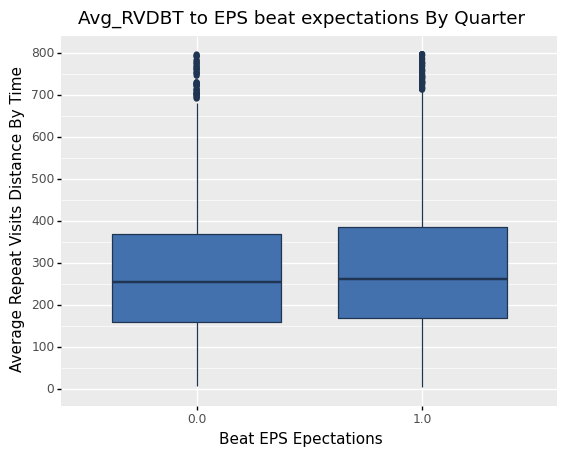

<ggplot: (8780217921259)>

In [ ]:
avg_rvdbt = (
    ggplot(k_df3, aes("eps_beat_expectations", "Avg_RVDBT"))
    + geom_boxplot(colour="#1F3552", fill="#4271AE")
    + xlab("Beat EPS Epectations")
    + ylab("Average Repeat Visits Distance By Time")
    + scale_y_continuous(breaks=np.arange(0, 801, 100), limits=[0, 800])
    + ggtitle("Avg_RVDBT to EPS beat expectations By Quarter")
)
avg_rvdbt

Out[100]:

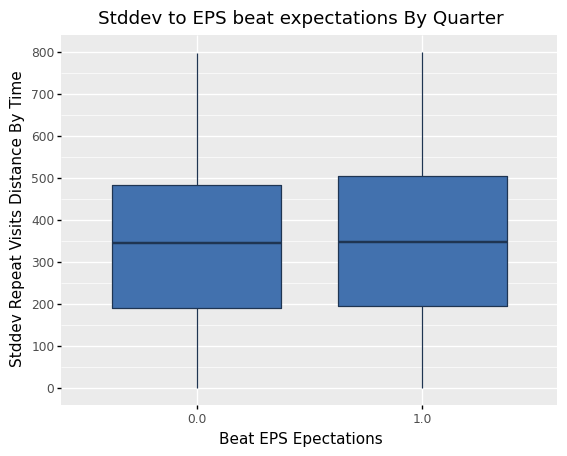

<ggplot: (8780398299901)>

In [ ]:
stddev_rvdbt = (
    ggplot(k_df3, aes("eps_beat_expectations", "Stddev_RVDBT"))
    + geom_boxplot(colour="#1F3552", fill="#4271AE")
    + xlab("Beat EPS Epectations")
    + ylab("Stddev Repeat Visits Distance By Time")
    + scale_y_continuous(breaks=np.arange(0, 801, 100), limits=[0, 800])
    + ggtitle("Stddev to EPS beat expectations By Quarter")
)
stddev_rvdbt

Out[101]:

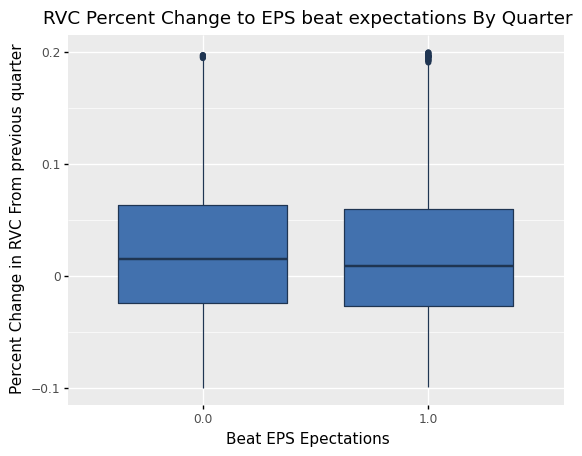

<ggplot: (8780426702939)>

In [ ]:
percent_change = (
    ggplot(k_df3, aes("eps_beat_expectations", "RVC_Percent_Change"))
    + geom_boxplot(colour="#1F3552", fill="#4271AE")
    + xlab("Beat EPS Epectations")
    + ylab("Percent Change in RVC From previous quarter")
    + scale_y_continuous(breaks=np.arange(-0.1, 0.2, 0.10), limits=[-0.1, 0.2])
    + ggtitle("RVC Percent Change to EPS beat expectations By Quarter")
)
percent_change

Out[109]:

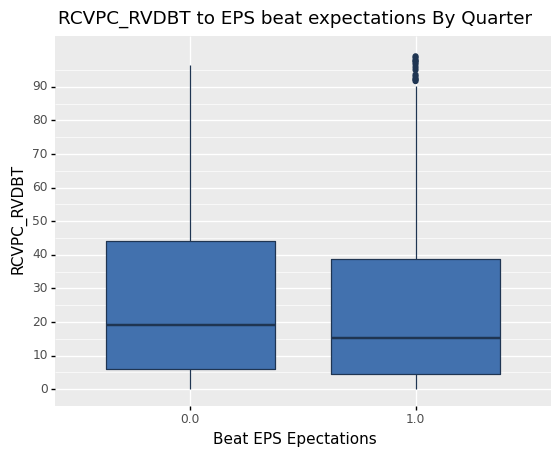

<ggplot: (8780344123191)>

In [ ]:
RCVPC_RVDBT = (
    ggplot(k_df3, aes("eps_beat_expectations", "RCVPC_RVDBT"))
    + geom_boxplot(colour="#1F3552", fill="#4271AE")
    + xlab("Beat EPS Epectations")
    + ylab("RCVPC_RVDBT")
    + scale_y_continuous(breaks=np.arange(0, 100, 10), limits=[0, 100])
    + ggtitle("RCVPC_RVDBT to EPS beat expectations By Quarter")
)
RCVPC_RVDBT